In [15]:
import sys
sys.path.append("../")
sys.path.append("../diffusion")

import utils
import guidance
import matplotlib.pyplot as plt
from pathlib import Path
import os
import torch
from torch_geometric.data import Data
import pickle

DEVICE = "cuda:0"

def plot_set(data_set, nrows = 3, ncols = 6):
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(12, 6)
    for i, (x, cond) in enumerate(data_set):
        img = utils.visualize_placement(x, cond)
        axes[i//ncols][i%ncols].imshow(img)
        axes[i//ncols][i%ncols].set_xticks([])
        axes[i//ncols][i%ncols].set_yticks([])
    plt.show()

def preprocess_placement(x, cond, scale=1):
    if len(cond.chip_size) == 4: # chip_size is [x_start, y_start, x_end, y_end]
        chip_size = (cond.chip_size[2] - cond.chip_size[0], cond.chip_size[3] - cond.chip_size[1])
        chip_offset = (cond.chip_size[0], cond.chip_size[1])
    else:
        chip_size = (cond.chip_size[0], cond.chip_size[1])
        chip_offset = (0, 0)
    chip_size = torch.tensor(chip_size, dtype = torch.float32).view(1, 2)
    chip_offset = torch.tensor(chip_offset, dtype = torch.float32).view(1, 2)
    x = (torch.tensor(x, dtype=torch.float32) - chip_offset)/scale
    x = 2 * (x / chip_size) - 1
    # use center of instance as coordinate point and reference for terminal
    x = x + cond.x/2
    return x

def eval_set(data_set, eval_fn, **kwargs):
    return [eval_fn(x, cond, normalized_hpwl=False, **kwargs)[1] for (x, cond) in data_set]

def plot_and_eval_set(data_set, eval_fn, nrows = 3, ncols = 6, title=None):
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(12, 6.2)
    if title:
        fig.suptitle(title)
    for i, (x, cond) in enumerate(data_set):
        img = utils.visualize_placement(x, cond)
        axes[i//ncols][i%ncols].imshow(img)
        axes[i//ncols][i%ncols].set_xticks([])
        axes[i//ncols][i%ncols].set_yticks([])
        metric = eval_fn(x, cond, normalized_hpwl=False)[1]
        axes[i//ncols][i%ncols].set_title(f"{metric:.0f}")
    plt.show()


## Load Dataset

### Load and Plot Data

Train set and val set sizes:  0 18
cuda:0 cuda:0


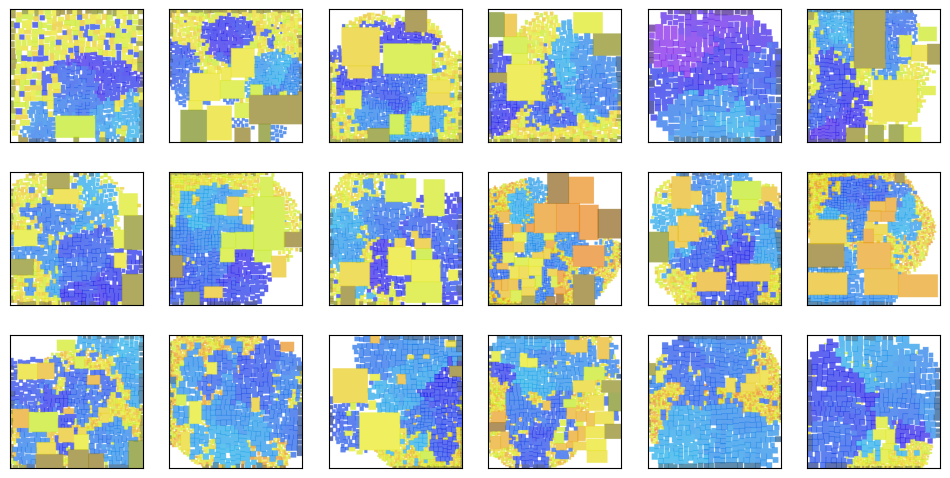

In [5]:
task = "ibm-cluster512"
placement_dir = "../logs/diffusion_debug/ibm-cluster512.eval_guided.300/samples"
train_set, val_set = utils.load_graph_data_with_config(
    task, 
    train_data_limit = None, 
    val_data_limit = None,
    )

print("Train set and val set sizes: ", len(train_set), len(val_set))

placement_paths = [os.path.join(placement_dir, f"sample{cond.file_idx}.pkl") for _, cond in val_set]
placements = [preprocess_placement(utils.open_pickle(path), cond) for path, (_, cond) in zip(placement_paths, val_set)]

placed_set = [(x.to(device=DEVICE), cond.to(device=DEVICE)) for x, (_, cond) in zip(placements, val_set)]
print(placed_set[0][0].device, placed_set[0][1].x.device)
# plot_set(val_set)
plot_set(placed_set)

### Evaluate Placements

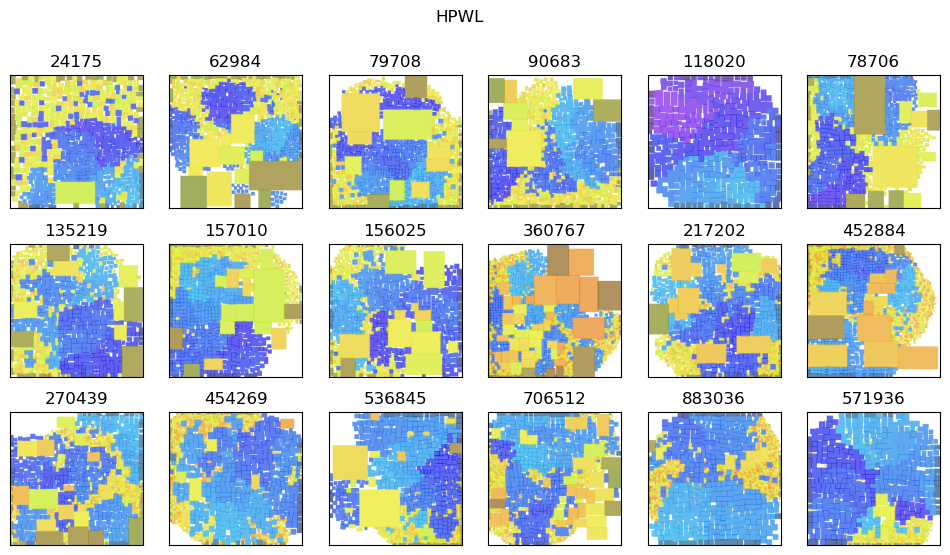

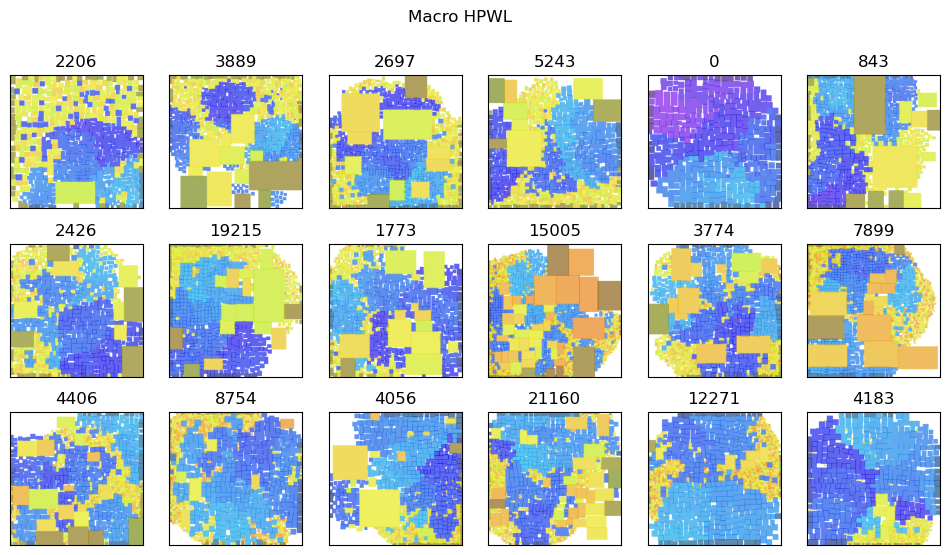

In [6]:
# print(eval_set(placed_set, utils.macro_hpwl))
plot_and_eval_set(placed_set, utils.hpwl_fast, title="HPWL")
plot_and_eval_set(placed_set, utils.macro_hpwl, title="Macro HPWL")

## Processing

### Removing Non-macros

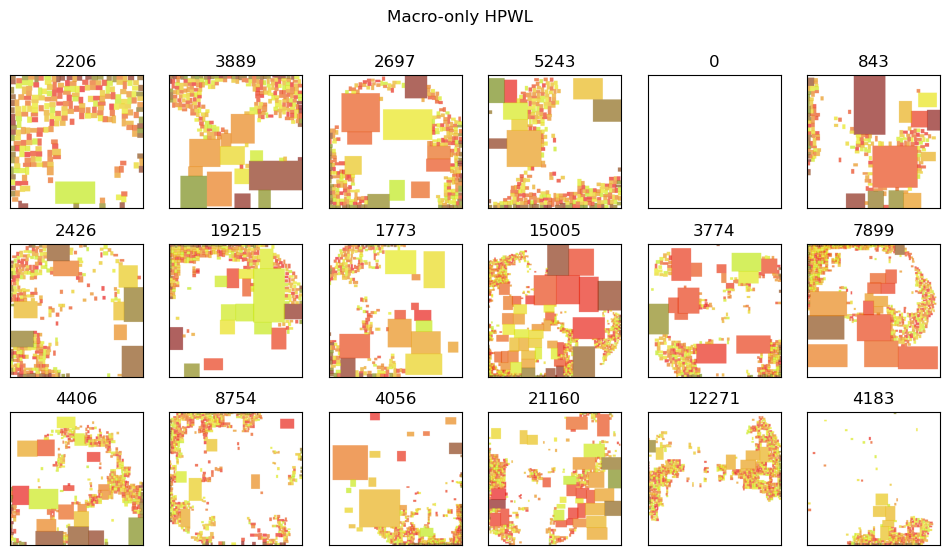

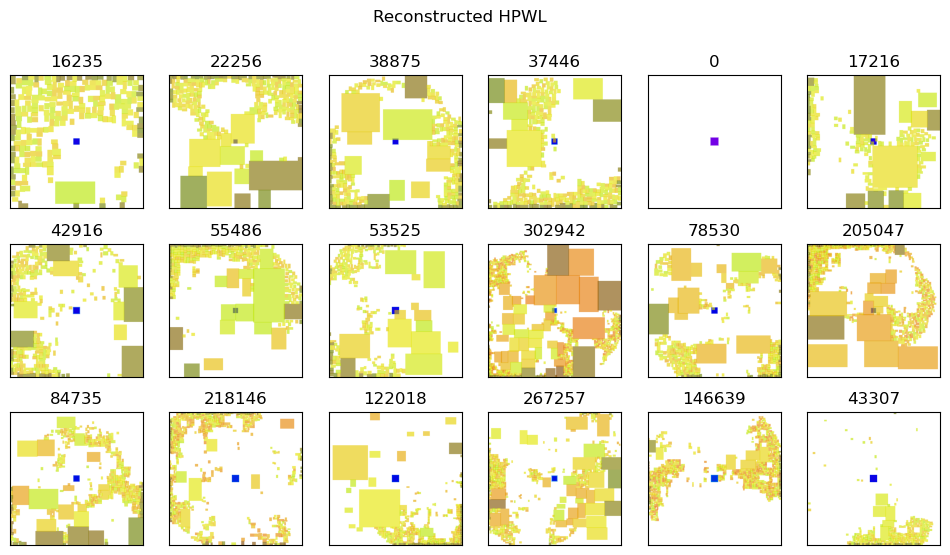

In [7]:
macro_only_set = [utils.remove_non_macros(x, cond) for (x,cond) in placed_set]
plot_and_eval_set(macro_only_set, utils.hpwl_fast, title="Macro-only HPWL")

reconstructed_set = [utils.add_non_macros(x, cond) for (x,cond) in macro_only_set]
plot_and_eval_set(reconstructed_set, utils.hpwl_fast, title="Reconstructed HPWL")

## Inspecting Results

cuda:0 cuda:0


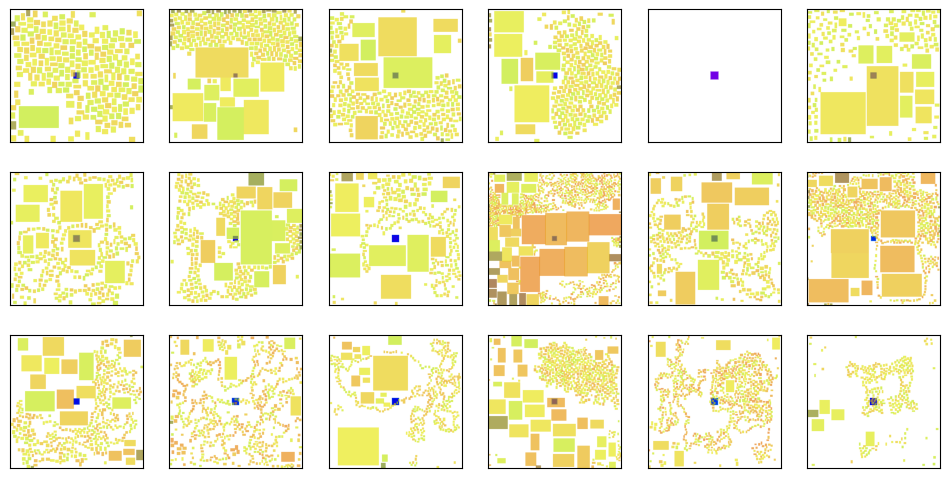

In [11]:
task = "ibm-cluster512"
placement_dir = "../logs/diffusion_debug/ibm-cluster512.eval_macro_only.300/samples"
_, val_set = utils.load_graph_data_with_config(
    task, 
    train_data_limit = None, 
    val_data_limit = None,
    )

placement_paths = [os.path.join(placement_dir, f"sample{cond.file_idx}.pkl") for _, cond in val_set]
placements = [preprocess_placement(utils.open_pickle(path), cond) for path, (_, cond) in zip(placement_paths, val_set)]

placed_set = [(x.to(device=DEVICE), cond.to(device=DEVICE)) for x, (_, cond) in zip(placements, val_set)]
print(placed_set[0][0].device, placed_set[0][1].x.device)
# plot_set(val_set)
plot_set(placed_set)